In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from progressbar import ProgressBar

from statsmodels.tsa.seasonal import STL
from sklearn.cluster import KMeans

%run ../global_variables.py ./
%run ../global_functions.py ./

# Mean seasonal pattern

In [2]:
def compute_mean_annual_hydro(hydro_month,hydro_var_name,data,basin_name,time_overlap):
    # select month in time_overlap
    hydro_basin=hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_overlap]].to_frame()
    hydro_basin.index=time_overlap
    
    # create a column month to group by
    hydro_basin['month']=hydro_basin.index.month
    hydro_basin_mean=hydro_basin.groupby('month').mean()
    hydro_basin_std=hydro_basin.groupby('month').std()
    
    # transform to Series
    hydro_basin_mean=pd.Series(hydro_basin_mean.values.flatten(),index=np.arange(1,13),name=basin_name)
    hydro_basin_std=pd.Series(hydro_basin_std.values.flatten(),index=np.arange(1,13),name=basin_name)
    return hydro_basin_mean,hydro_basin_std

## In a given basin

In [3]:
%matplotlib notebook
basins=load_basins_data()

In [4]:
data_TWS='GRACE_JPL_mascons'
TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly.csv'.format(data_TWS),index_col=[0])
time_TWS=pd.to_datetime(TWS_month.columns.str[4+len(data_TWS):])

<IPython.core.display.Javascript object>


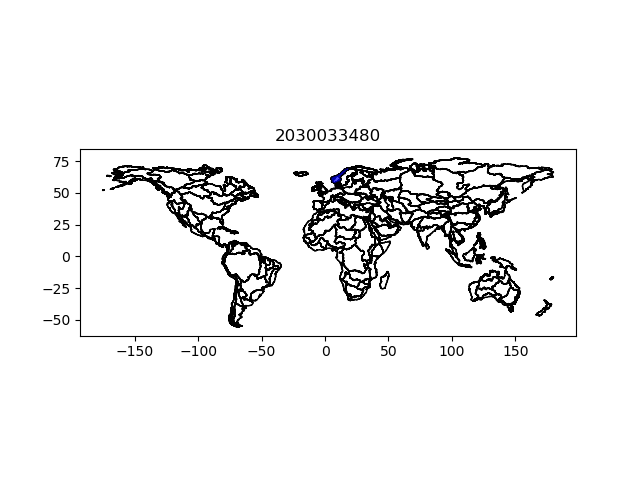

In [5]:
basin_id=basins.index[np.random.randint(basins.shape[0])]
#basin_id=4030050210 

fig, ax = plt.subplots()
ax.set_aspect('equal')
basins.plot(ax=ax, color='white', edgecolor='black')
basins.loc[[basin_id],'geometry'].plot(ax=ax, color='blue',alpha=0.7)
plt.title(basin_id)
plt.show()

In [6]:
TWS_mean,TWS_std=compute_mean_annual_hydro(TWS_month,'TWS',data_TWS,basin_id,time_TWS)

<IPython.core.display.Javascript object>


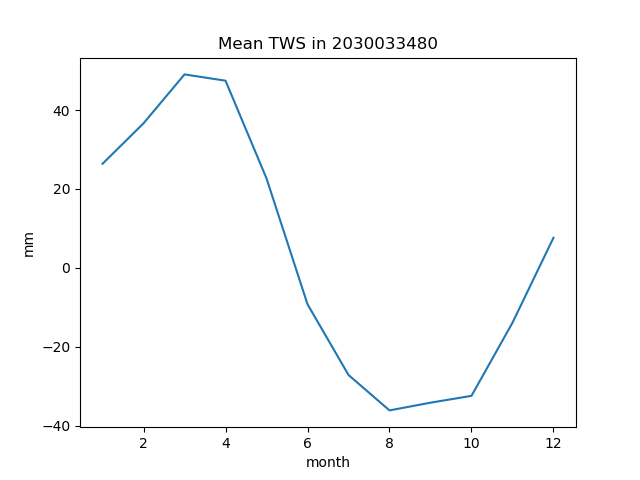

In [7]:
plt.figure()
plt.plot(TWS_mean)
plt.title('Mean TWS in {}'.format(basin_id))
plt.xlabel('month')
plt.ylabel('mm')
plt.show()

## In a selection of basins

In [8]:
basins=load_basins_data()

data_TWS='GRACE_JPL_mascons'
TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly.csv'.format(data_TWS),index_col=[0])
time_TWS=pd.to_datetime(TWS_month.columns.str[4+len(data_TWS):])

Prepare dataframe to store results : 
- mean seasonal pattern
- magnitude
- noise

In [9]:
seasonal_patterns=pd.DataFrame(np.zeros((14,1)),index=list(np.arange(1,13))+['sigma','magnitude'],
                               columns=[basins.index[0]])

Loop over basins

In [10]:
for basin_id in basins.index:
    TWS_mean,TWS_std=compute_mean_annual_hydro(TWS_month,'TWS',data_TWS,basin_id,time_TWS)
    noise=TWS_std.mean()
    magnitude=(TWS_mean.max()-TWS_mean.min())/2
    
    seasonal_patterns.loc[np.arange(1,13),basin_id]=TWS_mean
    seasonal_patterns.loc['sigma',basin_id]=noise
    seasonal_patterns.loc['magnitude',basin_id]=magnitude

Kmeans algorithm to create cluster of basins depending on the shape of their mean seasonal water storage

In [63]:
pattern_norm=normalize(seasonal_patterns.iloc[:12,:],a=-1,b=1)

# number of cluster we assume
Nclusters=4
kmeans = KMeans(n_clusters=Nclusters).fit(pattern_norm.values.T)

basins_k=[] # list of k lists, each one containing the basin names in the corresponding cluster
nb_basins_per_k=[] # number of basins per cluster
for k in range(Nclusters):
    X=np.where(kmeans.labels_==k)[0]
    basins_k.append(basins.index[X])
    nb_basins_per_k.append(X.shape[0])

In [64]:
for k in range(Nclusters):
    seasonal_patterns.loc['cluster',basins_k[k]]=k
seasonal_patterns

,1030000010,1030003990,1030008100,1030008110,1030011660,1030011670,1030012590,1030012600,1030015030,1030015850,...,7030065760,7030070790,7030073620,8030000010,8030005510,8030005520,8030009560,8030009570,8030010700,8030016860
1,-4.020947,7.938722,13.930948,3.652337,52.652279,7.903233,8.181194,7.394150,9.142627,5.870828,...,2.536808,16.035858,-12.065280,-218.094883,-44.825459,18.153652,-25.083219,-25.130585,15.923678,-2.031591
2,-5.311077,10.139879,4.226047,50.486576,131.837627,28.034023,17.807566,10.823346,8.372654,10.484785,...,-28.308707,-2.574826,13.226253,-188.067201,-26.373738,31.775789,-13.593846,-14.459885,27.403404,2.169730
3,-10.631657,7.942296,1.467754,77.904901,176.002624,35.184707,17.550433,10.017401,5.821415,10.669283,...,-55.558259,-13.346493,28.998388,-164.942623,-8.884632,43.722896,-1.556833,-3.471693,40.050284,9.847641
4,-18.114557,8.035587,11.415066,90.241541,156.958427,15.301524,10.197891,8.914199,5.518163,9.665784,...,-61.589795,-22.350124,34.782008,-101.223746,13.259340,58.032044,9.934370,10.265214,49.321137,21.222049
5,-27.483833,8.370512,28.176971,66.500224,99.473991,-16.891430,-5.163432,5.430513,6.728949,7.186885,...,-38.956216,-13.224644,23.001914,-127.371823,4.217636,61.183585,8.980641,24.362383,58.385180,27.609408
6,-31.000802,6.057502,23.596551,22.761067,38.902762,-35.176972,-16.708209,0.668096,9.776813,3.323061,...,12.046436,8.474690,-7.291813,-199.143789,-53.485642,16.881072,-19.306110,-25.301524,43.679113,16.058052
7,-19.516543,6.677586,20.917276,-6.175272,-6.213962,-48.468709,-20.672947,1.699484,15.279363,5.262929,...,45.325943,18.054421,-49.790032,-292.902478,-105.989823,-13.872074,-47.485602,-67.389117,-18.484530,-28.186563
8,-0.809721,7.676066,17.593520,-37.604657,-45.301142,-60.492449,-29.227777,2.313839,18.397827,4.781874,...,54.051223,24.593615,-78.489359,-372.339615,-133.167747,-17.189971,-64.186656,-77.324366,-39.804464,-46.968794
9,9.938667,8.044483,19.378903,-53.208281,-81.122744,-69.310879,-33.688991,0.794412,19.520122,3.137349,...,64.717394,45.634035,-98.240984,-418.251709,-146.722799,-23.081048,-75.586559,-88.633912,-48.214288,-49.780300
10,11.091185,8.940984,23.280631,-73.625108,-106.250458,-76.002573,-34.245376,-0.886012,16.776721,0.385603,...,70.004640,52.952943,-98.769909,-373.221772,-130.753529,-21.438590,-76.764060,-84.941132,-36.518350,-40.203134


In [65]:
N=seasonal_patterns.shape[1]
max_nb_basins_per_k=np.max(nb_basins_per_k)
markerstyles = ['.','2','+','x',9,10]

color_cluster=['tab:pink','tab:olive','tab:purple','tab:cyan','tab:brown','lightgrey']

Print the mean pattern of basins in cluster k

<IPython.core.display.Javascript object>


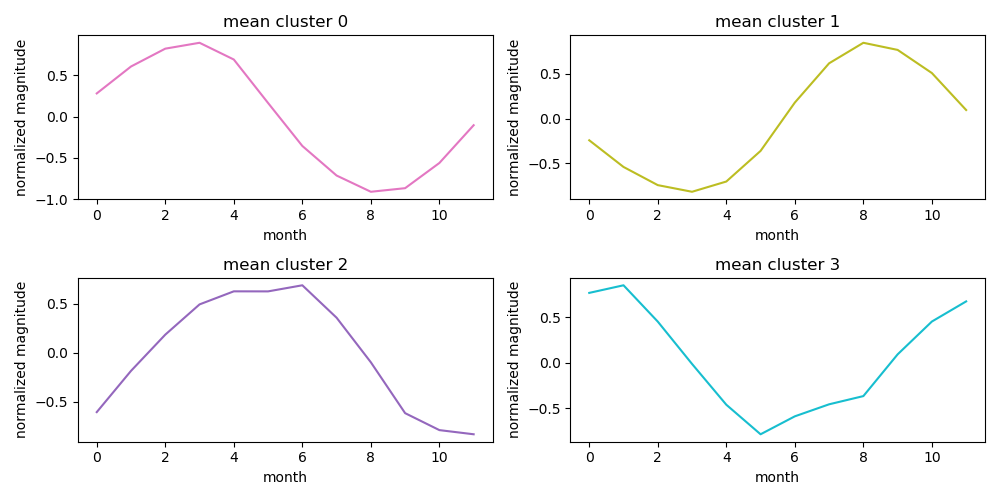

In [66]:
plt.figure(figsize=(10,5))
for k in range(Nclusters):
    plt.subplot(Nclusters//2,2,k+1)
    plt.plot(kmeans.cluster_centers_[k,:],'k',color=color_cluster[k])
    plt.title('mean cluster {}'.format(k))
    plt.xlabel('month')
    plt.ylabel('normalized magnitude')
plt.tight_layout()
plt.show()

Plot the cluster map

In [67]:
basins_cluster=basins.join(seasonal_patterns.loc['cluster'].to_frame())
basins_cluster['cluster']=basins_cluster['cluster'].astype(int)

<IPython.core.display.Javascript object>


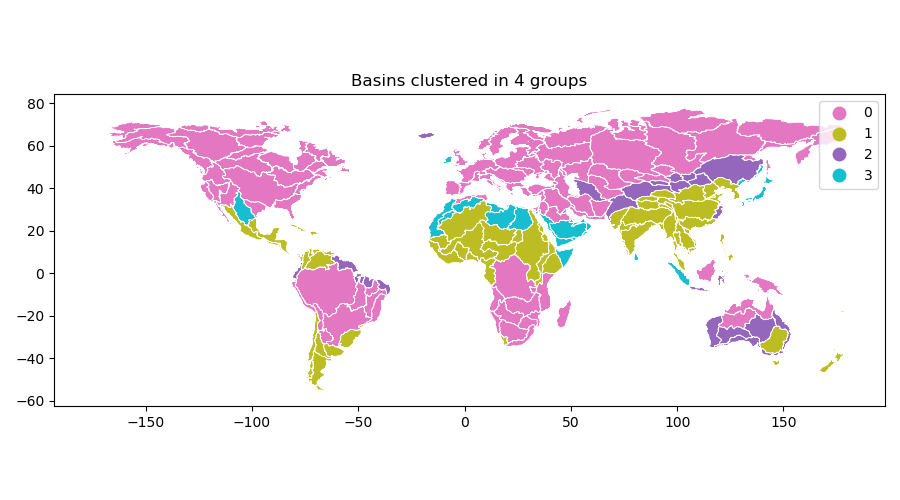

In [69]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_aspect('equal')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.1)
basins_cluster.plot(ax=ax,edgecolor='white',linewidth=0.5,column='cluster',categorical=True,
                    cmap=ListedColormap(color_cluster[:Nclusters]),legend=True)
ax.set_title('Basins clustered in {} groups'.format(Nclusters))
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


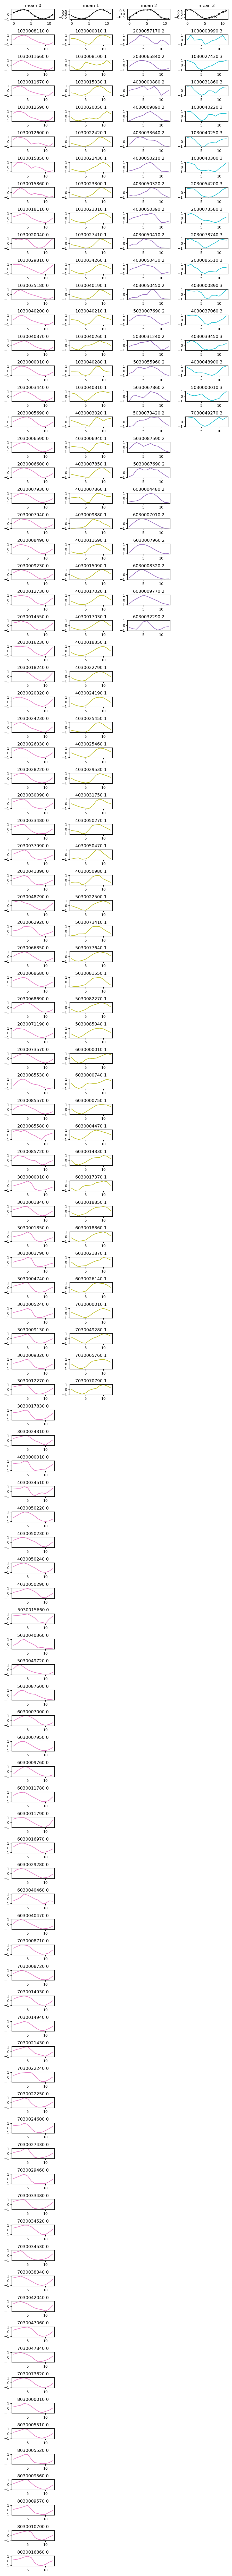

In [40]:
plt.figure(figsize=(9,max_nb_basins_per_k))
for k in range(Nclusters):
    plt.subplot(max_nb_basins_per_k+1,Nclusters,k+1)
    plt.plot(kmeans.cluster_centers_[k,:],'k',marker=markerstyles[k])
    plt.title('mean {}'.format(k))
    
    for i,basin_id in enumerate(basins_k[k]):
        plt.subplot(max_nb_basins_per_k+1,Nclusters,Nclusters*(i+1)+k+1)
        plt.plot(pattern_norm.loc[:,basin_id],
                 color=color_cluster[k],
                #marker=markerstyles[k]
                )
        plt.title('{} {}'.format(basin_id,k))
plt.tight_layout()
plt.show()

# Link between cluster and climate zone

In [87]:
basins=load_basins_data(details=True)
basins['cluster']=seasonal_patterns.loc['cluster']
basins

,AREA,CLIMATE_DETAILS,PERCENT_LAKE,DEGREE_OF_REGULATION,CLIMATE_NAME,CLIMATE,geometry,cluster
HYBAS_ID,,,,,,,,
1030000010,2.336584e+05,17,0.0,0.0,Extremely hot and xeric,16,"POLYGON ((37.19167 21.13333, 37.19106 21.14909...",1.0
1030003990,5.167208e+05,17,0.0,0.0,Extremely hot and xeric,16,"POLYGON ((44.03333 1.10833, 44.02988 1.10745, ...",3.0
1030008100,7.943913e+05,17,0.0,4.4,Extremely hot and xeric,16,"POLYGON ((36.74167 4.06667, 36.74131 4.06909, ...",1.0
1030008110,1.034723e+06,18,0.3,0.0,Extremely hot and moist,13,"MULTIPOLYGON (((36.95833 -18.02917, 36.96235 -...",0.0
1030011660,1.373188e+06,14,2.8,209.9,Hot and dry,16,"POLYGON ((35.26250 -18.23333, 35.26215 -18.244...",0.0
...,...,...,...,...,...,...,...,...
8030005520,3.686874e+05,6,3.5,0.0,Extremely cold and wet 2,4,"POLYGON ((-143.99167 70.06667, -143.99097 70.0...",0.0
8030009560,1.805884e+06,7,10.2,26.1,Extremely cold and mesic,4,"POLYGON ((-117.24167 52.90417, -117.24910 52.9...",0.0
8030009570,1.550338e+05,6,11.6,0.0,Extremely cold and wet 2,4,"POLYGON ((-133.00000 69.58333, -132.99923 69.5...",0.0


In [92]:
list_climate=np.unique(basins['CLIMATE'])
df=pd.DataFrame(np.zeros((len(list_climate),Nclusters)),index=list_climate,columns=np.arange(Nclusters))

for climate in list_climate:
    for cluster in range(Nclusters):
        df.loc[climate,cluster]=basins.loc[(basins['CLIMATE']==climate)&(basins['cluster']==cluster)].shape[0]

df.index=['Cold and wet','Temperate and dry','Temperate and moist','Hot and moist','Hot and dry']
df.loc['Total']=np.sum(df,axis=0)
df['all']=np.sum(df,axis=1)
df

,0,1,2,3,all
Cold and wet,39.0,4.0,3.0,2.0,48.0
Temperate and dry,25.0,6.0,8.0,1.0,40.0
Temperate and moist,8.0,8.0,0.0,2.0,18.0
Hot and moist,14.0,20.0,8.0,2.0,44.0
Hot and dry,14.0,16.0,5.0,9.0,44.0
Total,100.0,54.0,24.0,16.0,194.0


In [95]:
save_clusters=seasonal_patterns.loc['cluster'].to_frame()
#save_clusters.to_csv("../results/Kmeans_clusters_N{}.csv".format(Nclusters))